In [ ]:
import pandas as pd
import numpy as np
from numpy.lib import polynomial
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from scipy.stats import norm, boxcox
from scipy import stats

import seaborn as sns
import joblib

df=pd.read_csv('used_device_data.csv', index_col = 0)
# df.head()

In [ ]:
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3450.000000,3450.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.573099,4.036122,3133.402697,182.751871,2015.965258,674.869716,4.364712,5.233107
std,3.805280,4.815461,6.970372,84.972371,1.365105,1299.682844,88.413228,2.298455,248.580166,0.588914,0.683637
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


### Checking missing values and drop those missing values

In [ ]:
df.isnull().sum()

os                         0
screen_size                0
4g                         0
5g                         0
rear_camera_mp           179
front_camera_mp            2
internal_memory            4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

In [ ]:
df = df.dropna()

### Check Distribution of the data

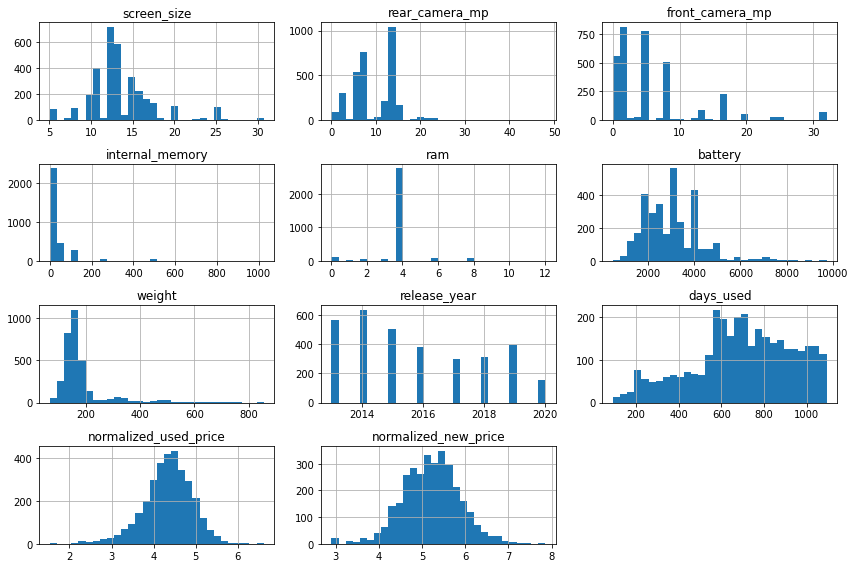

In [ ]:
df.hist(figsize=(12,8),bins=30)
plt.tight_layout()

### Visualize relationship between variables to check which relationship shall be use to do regression analysist

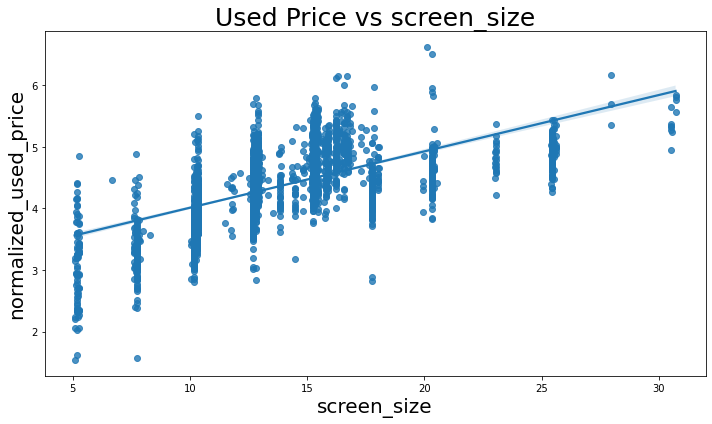

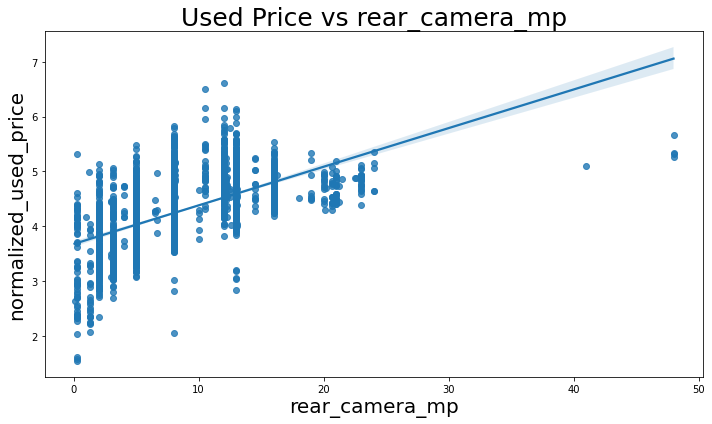

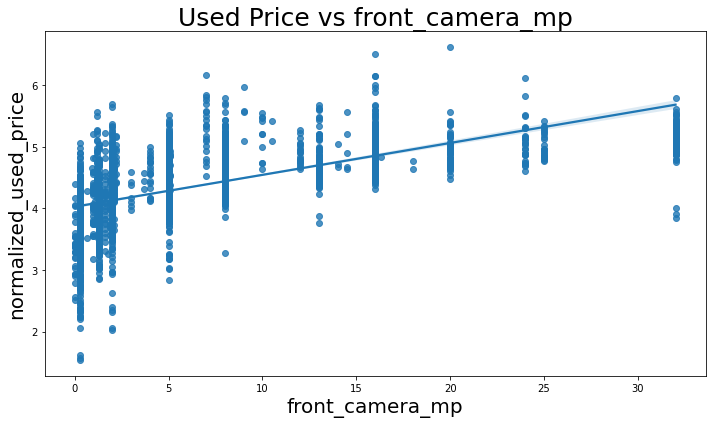

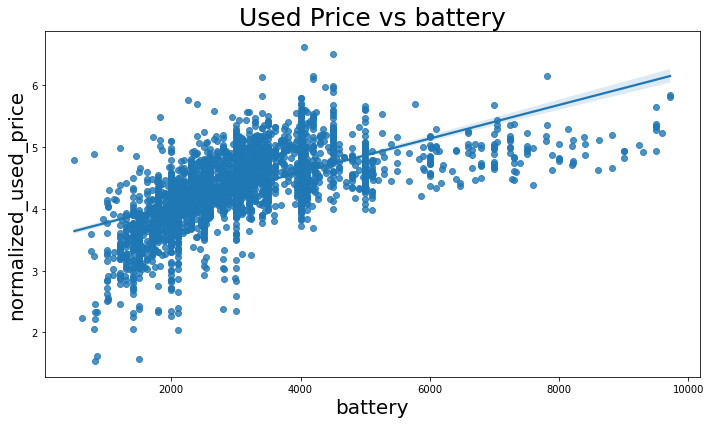

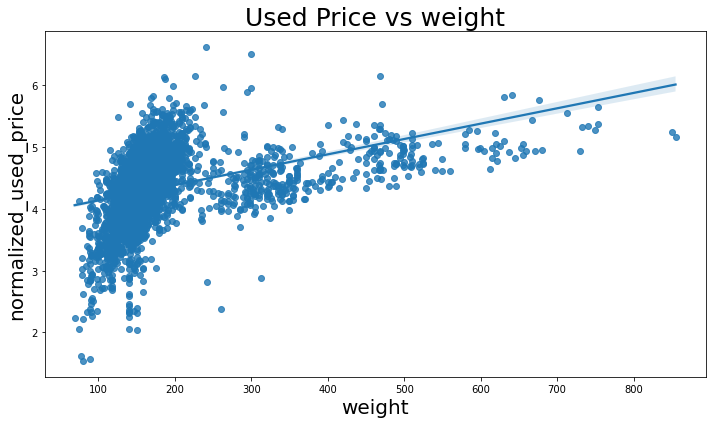

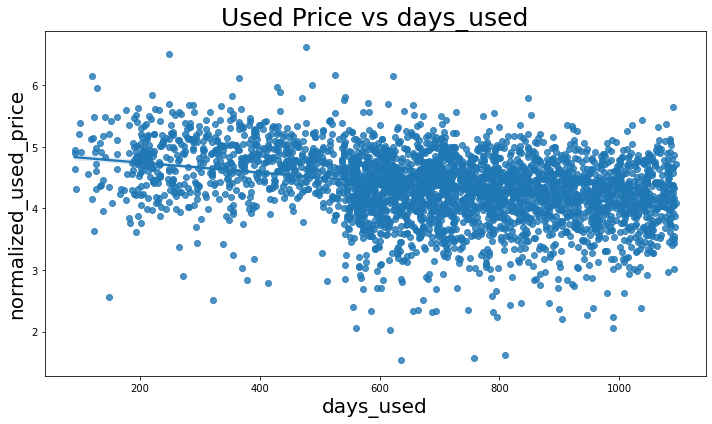

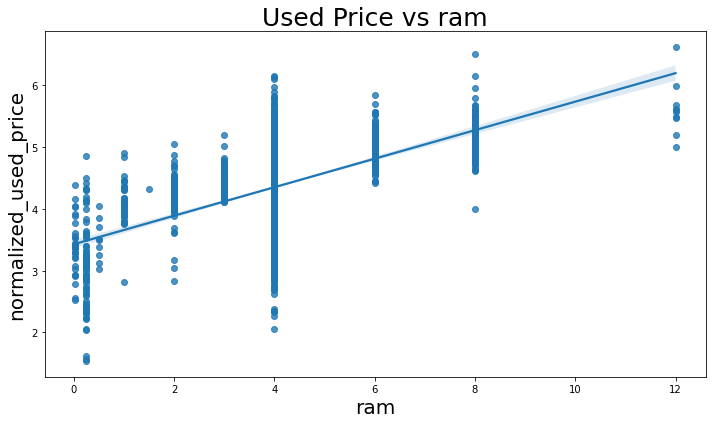

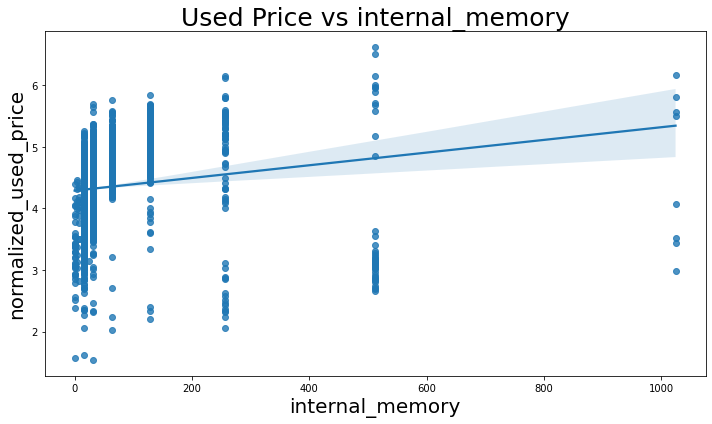

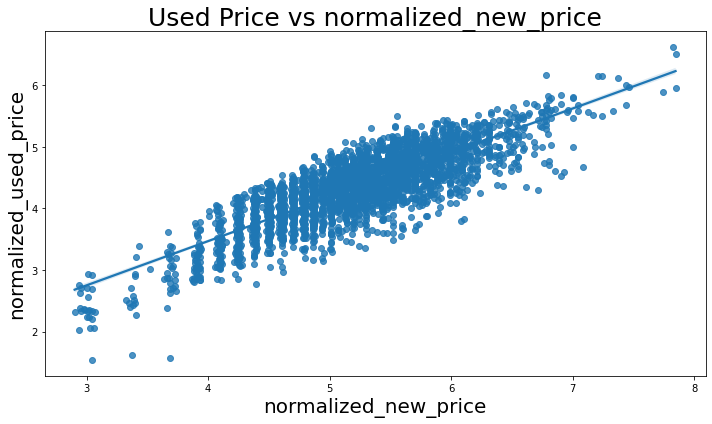

In [ ]:
def vairables_analysis(x):
    plt.figure(figsize=(10,6))
    ax = sns.regplot(x=x, y='normalized_used_price',data=df)
    ax.set_title("Used Price vs "+x, fontsize=25)
    ax.set_xlabel(x, fontsize=20)
    ax.set_ylabel('normalized_used_price', fontsize=20)
    plt.locator_params(axis='x', nbins=10)

cols = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used','ram','internal_memory','normalized_new_price']
for x in cols:
    vairables_analysis(x)
    plt.tight_layout()

### Analyze Multiple variable correlation 

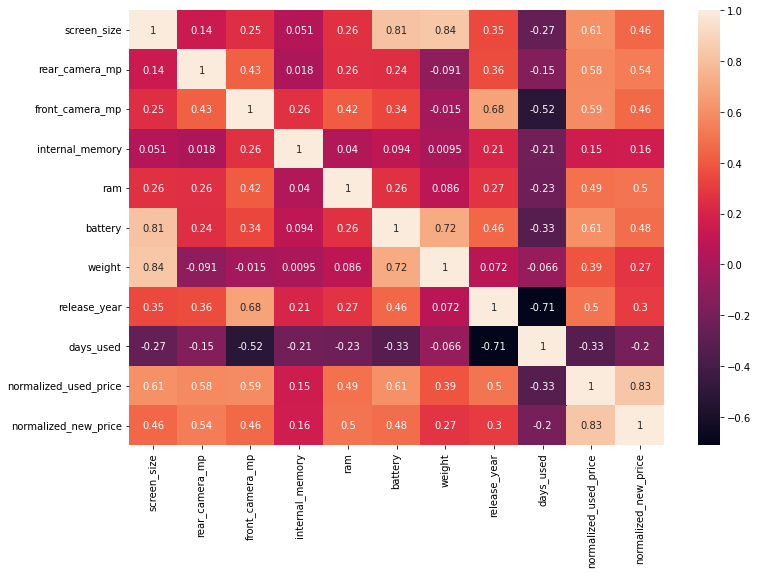

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

### Checking for Outliers

In [ ]:
cols2 = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used','normalized_new_price','normalized_used_price']

def detect_outliers(columns):
    outlier_indices = []

    for column in columns:
        # 1st quartile
        Q1 = np.percentile(df[column], 25)
        # 3st quartile
        Q3 = np.percentile(df[column], 75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[column] < Q1 - outlier_step)
                              | (df[column] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
        return outlier_indices

len(detect_outliers(cols2))

440

### Checking Swagging data

Before Correcting
Mu before correcting SCREEN_SIZE : 13.617476175837686, Sigma before correcting SCREEN_SIZE : 3.850927722248345


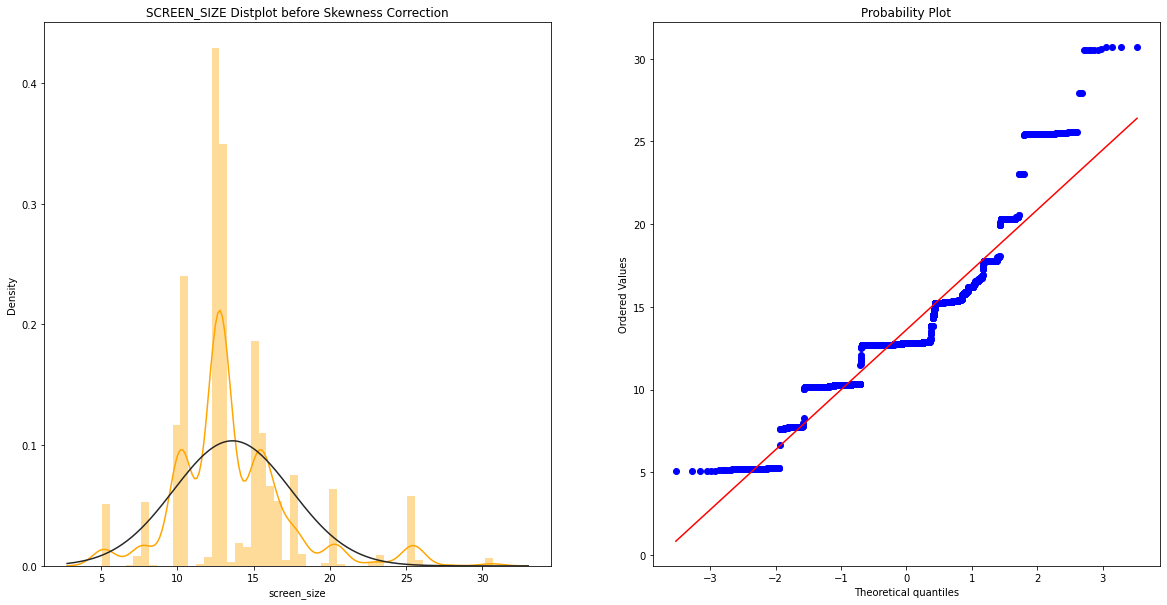

Before Correcting
Mu before correcting REAR_CAMERA_MP : 9.476354134644943, Sigma before correcting REAR_CAMERA_MP : 4.801461330992338


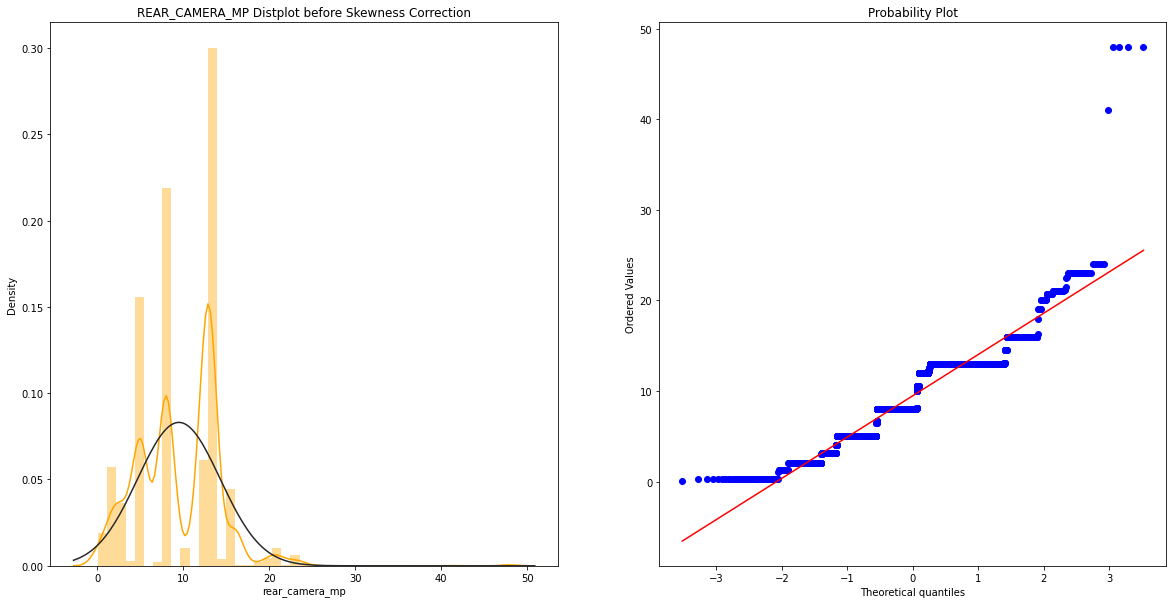

Before Correcting
Mu before correcting FRONT_CAMERA_MP : 6.093790347371658, Sigma before correcting FRONT_CAMERA_MP : 6.59856537717815


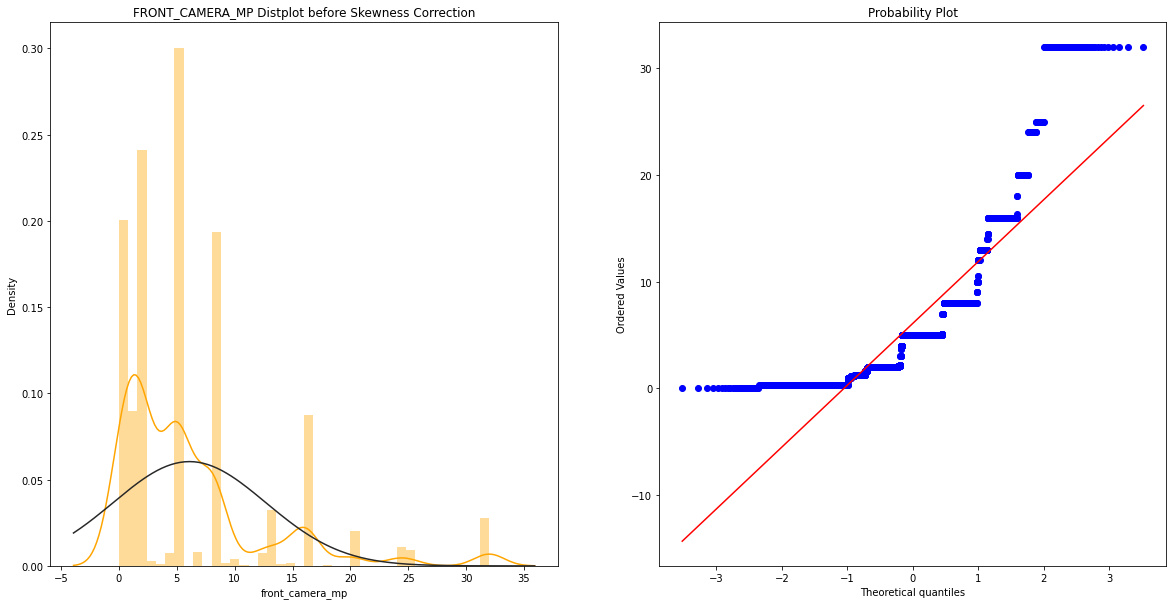

Before Correcting
Mu before correcting BATTERY : 3074.926990470335, Sigma before correcting BATTERY : 1296.758255626418


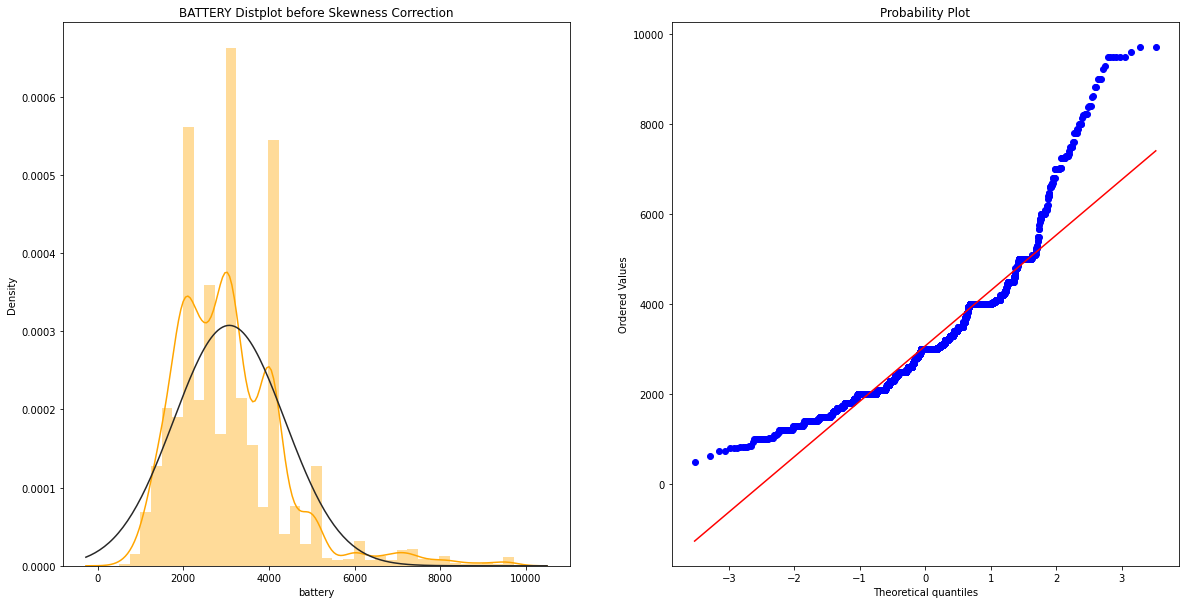

Before Correcting
Mu before correcting WEIGHT : 182.49363664309868, Sigma before correcting WEIGHT : 90.34592055359136


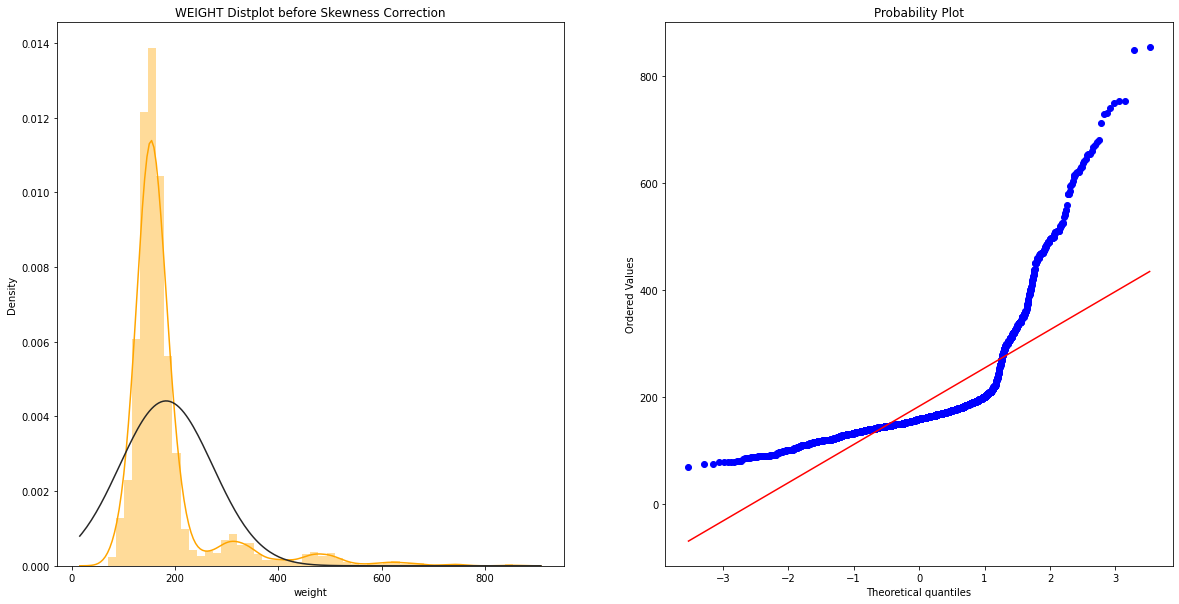

Before Correcting
Mu before correcting DAYS_USED : 695.695358130956, Sigma before correcting DAYS_USED : 235.4178911895456


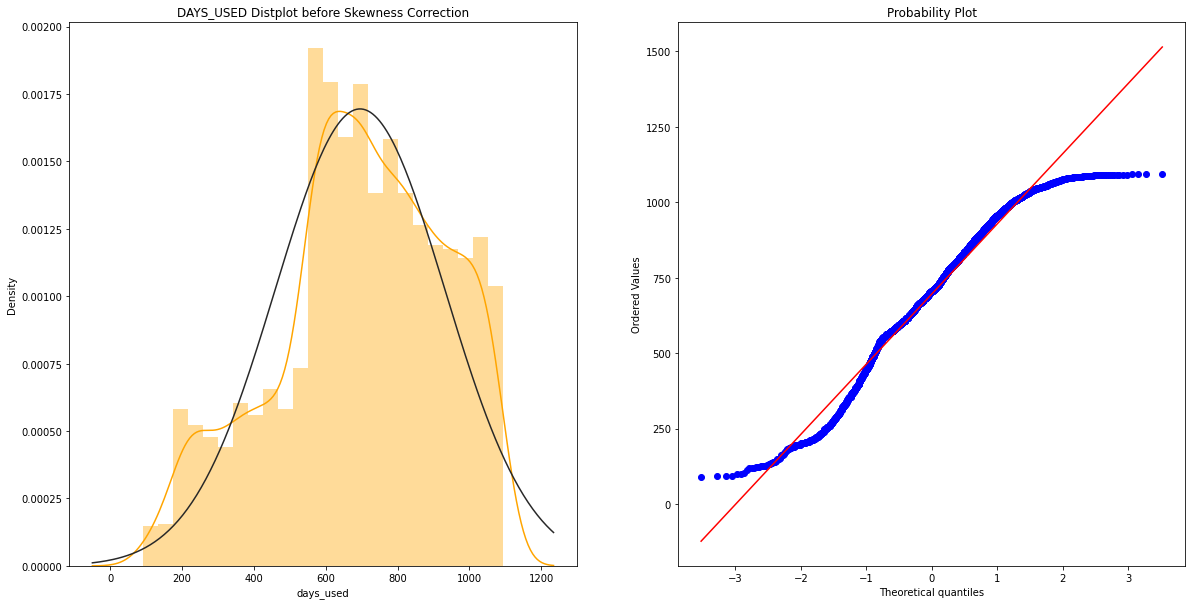

In [ ]:
def check_skweness(columnName):
    print('''Before Correcting''')
    try:
        (mu, sigma) = norm.fit(df[columnName])
    except RuntimeError:
        (mu,sigma) = norm.fit(df[columnName].dropna())
    print("Mu before correcting {} : {}, Sigma before correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.distplot(df[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot before Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(df[columnName], plot=plt)
    plt.show();

skew_check_cols = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used']

for columns in skew_check_cols:
    check_skweness(columns)

### Transformation to get normalize data

In [ ]:
def trying_different_transformations(column,transformation):
    if transformation=='boxcox':
        try:
            print("BoxCox - "+column)
            temp,temp_params = boxcox(df[column]+1)
            (mu,sigma)=norm.fit(temp)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp, plot = plt)
        except ValueError:
            pass
        except ValueError:
            pass
    elif transformation=='log':
        try:
            print("Log - "+column)
            (mu,sigma)=norm.fit(np.log1p(df[column]))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(np.log1p(df[column]), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(np.log1p(df[column]), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='reciprocal':
        try:
            print("Reciprocal - "+column)
            temp_r = 1/df[column]
            temp_r = temp_r.replace([np.inf, -np.inf], 0)
            (mu,sigma)=norm.fit(temp_r)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp_r, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp_r, plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='sqroot':
        try:
            print("Square_Root - "+column)
            (mu,sigma)=norm.fit(df[column]**(1/2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(df[column]**(1/2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(df[column]**(1/2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    else:
        try:
            print("Exponential - "+column)
            (mu,sigma)=norm.fit(df[column]**(1/1.2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(df[column]**(1/1.2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(df[column]**(1/1.2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass

In [ ]:
def skweness_correction(columnName):    
    if columnName == 'front_camera_mp' or columnName == 'screen_size' or columnName == 'battery':
        df[columnName], temp_params = boxcox(
        df[columnName]+1)
    elif columnName == 'weight':
        df[columnName] = 1/df[columnName].replace([np.inf, -np.inf], 0)
    elif columnName =='rear_camera_mp':
        df[columnName] = df[columnName]**(1/2)
    print('''After Correcting''')
    (mu, sigma) = norm.fit(df[columnName])
    print("Mu after correcting {} : {}, Sigma after correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    sns.distplot(df[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot After Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(df[columnName], plot = plt)
    plt.show();

In [ ]:
len(detect_outliers(cols2))

440

In [ ]:
transformations = ['boxcox','log','reciprocal','sqroot','exp']

After Correcting
Mu after correcting SCREEN_SIZE : 3.5698405645584037, Sigma after correcting SCREEN_SIZE : 0.4545136604498212


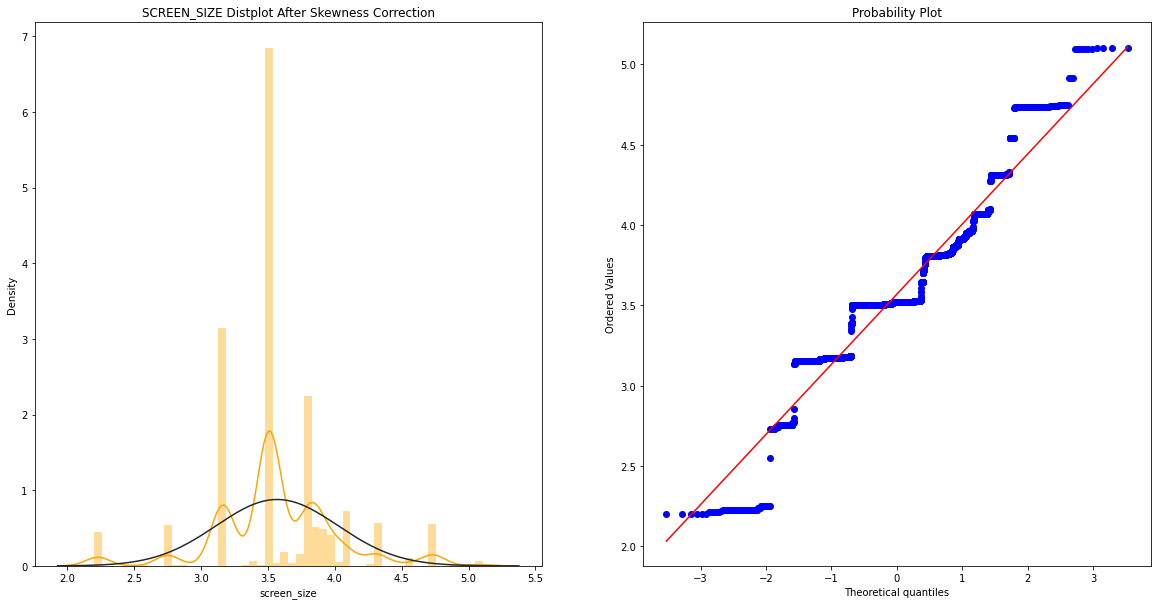

After Correcting
Mu after correcting REAR_CAMERA_MP : 2.9592967600910938, Sigma after correcting REAR_CAMERA_MP : 0.847889627462975


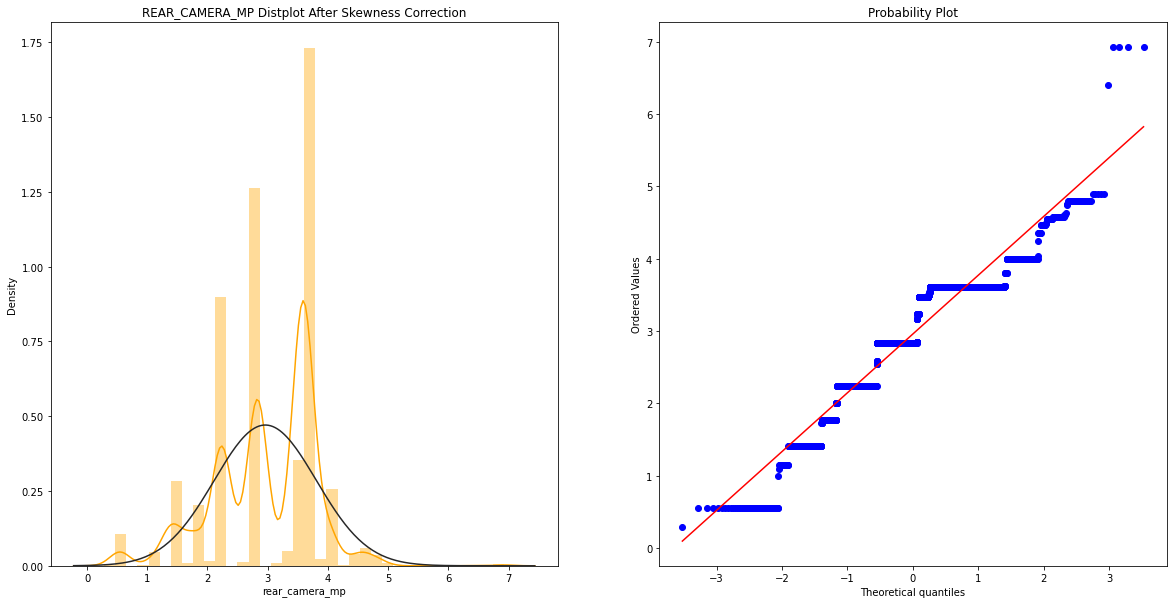

After Correcting
Mu after correcting FRONT_CAMERA_MP : 1.5268144858285813, Sigma after correcting FRONT_CAMERA_MP : 0.8193688139683319


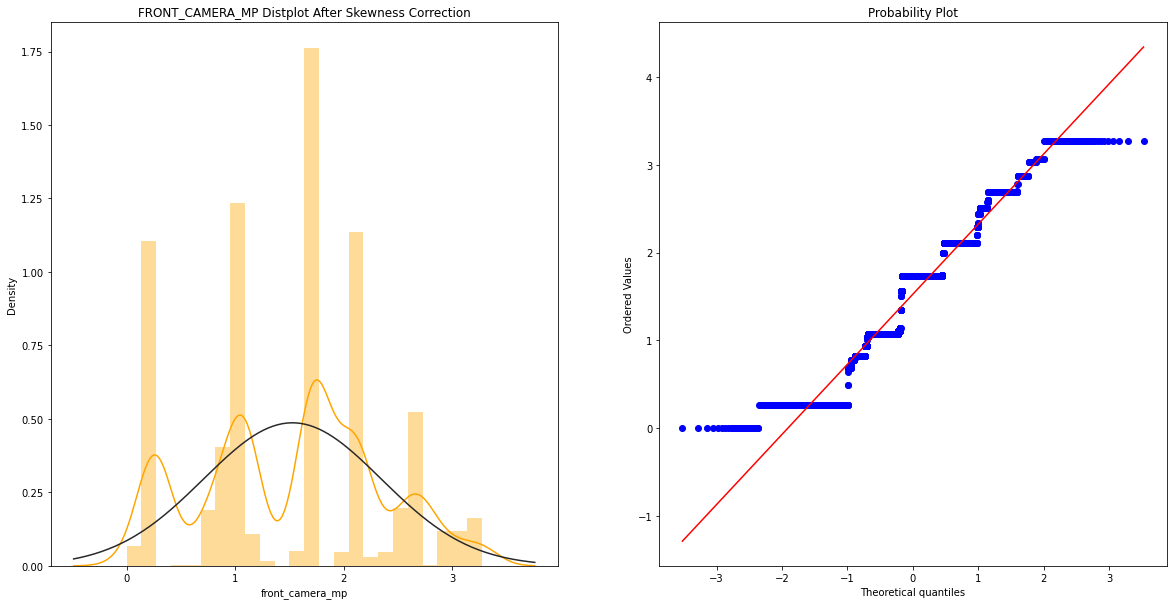

After Correcting
Mu after correcting BATTERY : 9.140952023574444, Sigma after correcting BATTERY : 0.5274073169353909


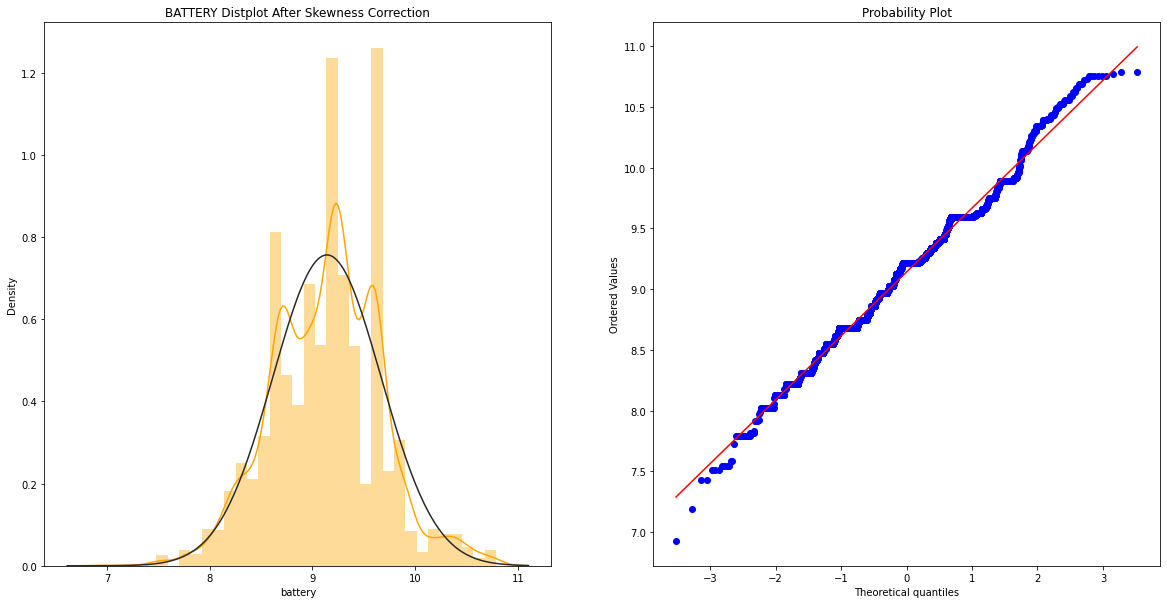

After Correcting
Mu after correcting WEIGHT : 0.006213180426972396, Sigma after correcting WEIGHT : 0.0017488702471315902


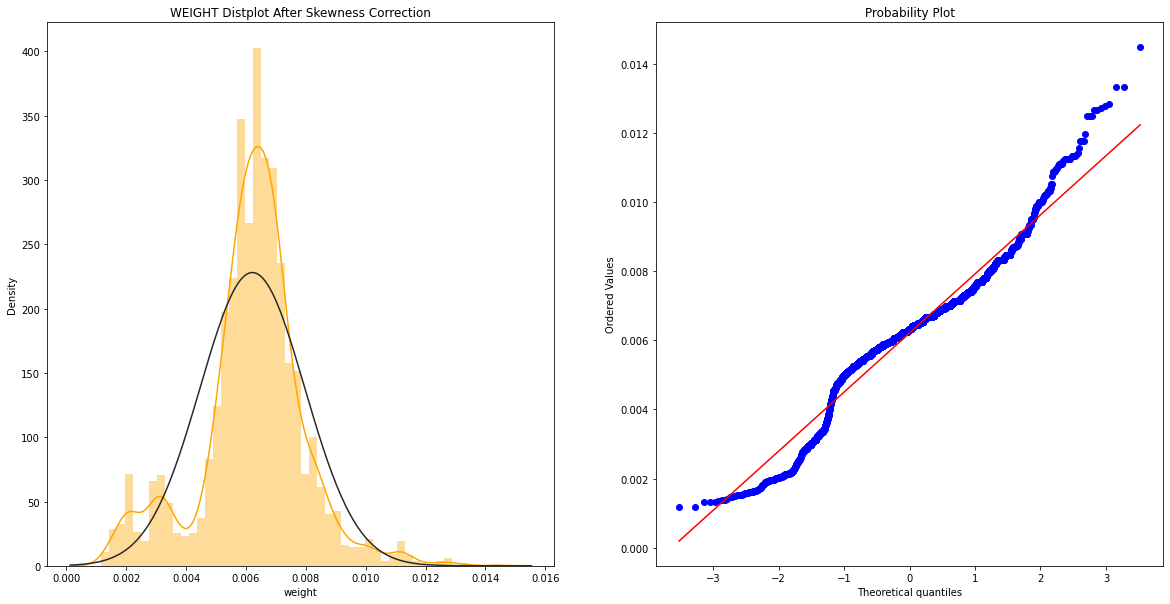

In [ ]:
def skweness_correction(columnName):    
    if columnName == 'front_camera_mp' or columnName == 'screen_size' or columnName == 'battery':
        df[columnName], temp_params = boxcox(
        df[columnName]+1)
    elif columnName == 'weight':
        df[columnName] = 1/df[columnName].replace([np.inf, -np.inf], 0)
    elif columnName =='rear_camera_mp':
        df[columnName] = df[columnName]**(1/2)
    print('''After Correcting''')
    (mu, sigma) = norm.fit(df[columnName])
    print("Mu after correcting {} : {}, Sigma after correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    sns.distplot(df[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot After Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(df[columnName], plot = plt)
    plt.show();

skewColumnList1 = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight']

for columns in skewColumnList1:
    skweness_correction(columns)

In [ ]:
len(detect_outliers(cols2))

435

In [ ]:
df.shape[0]

3253

### Defined X and Y

In [ ]:
X = df['screen_size'].values.reshape(-1,1)
y = df['normalized_used_price'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

kfold = KFold(n_splits = 10, shuffle = True, random_state = 100)

lr = LinearRegression()
lr.fit(X_train, y_train)

cv_scores = cross_val_score(lr, X_train, y_train, cv = kfold)

X_test.shape[0]

976

### Linear Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

for i in range(1,20):

  steps = [("imp_mean", SimpleImputer()), 
           ("scaler", StandardScaler()),
           ("transform", PolynomialFeatures(degree = 3)),
           ("liReg", LinearRegression())]

  pipeline = Pipeline(steps)
  
  pipeline.fit(X_train, y_train)

  rscore_test = pipeline.score(X_test, y_test)
  rscore_train = pipeline.score(X_train, y_train)

  y_pred = pipeline.predict(X_test)

  print(i, "test: ", rscore_test, "train: ", rscore_train)

1 test:  0.4162422461345142 train:  0.48676250921534214
2 test:  0.4162422461345142 train:  0.48676250921534214
3 test:  0.4162422461345142 train:  0.48676250921534214
4 test:  0.4162422461345142 train:  0.48676250921534214
5 test:  0.4162422461345142 train:  0.48676250921534214
6 test:  0.4162422461345142 train:  0.48676250921534214
7 test:  0.4162422461345142 train:  0.48676250921534214
8 test:  0.4162422461345142 train:  0.48676250921534214
9 test:  0.4162422461345142 train:  0.48676250921534214
10 test:  0.4162422461345142 train:  0.48676250921534214
11 test:  0.4162422461345142 train:  0.48676250921534214
12 test:  0.4162422461345142 train:  0.48676250921534214
13 test:  0.4162422461345142 train:  0.48676250921534214
14 test:  0.4162422461345142 train:  0.48676250921534214
15 test:  0.4162422461345142 train:  0.48676250921534214
16 test:  0.4162422461345142 train:  0.48676250921534214
17 test:  0.4162422461345142 train:  0.48676250921534214
18 test:  0.4162422461345142 train:  0.4

In [ ]:
print(cv_scores)

[0.44606544 0.31098732 0.47594776 0.47137537 0.42861941 0.41281063
 0.51204637 0.43985687 0.41392804 0.48227076]


In [ ]:
normalize = MinMaxScaler()
X_scaled = normalize.fit_transform(X)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_scaled, y)
print(lr.coef_, lr.intercept_, "\n")

y_pred = lr.predict(X_scaled)
rscore = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print('r2-score:', rscore, '\nmean squared error:', mse, '\nmean absolute error:', mae)
print("")
print("actual Price:",y[2], "Predict Price:",y_pred[2], "Differece:", y[2]-y_pred[2])

[[2.43580294]] [3.19396551] 

r2-score: 0.4328377236726655 
mean squared error: 0.19034951820735757 
mean absolute error: 0.3453689071829896

actual Price: [5.11108377] Predict Price: [4.66984995] Differece: [0.44123381]


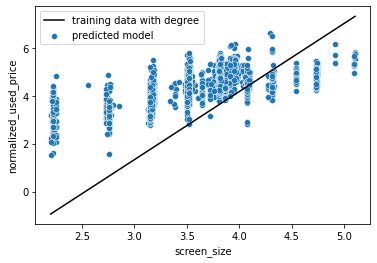

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.scatterplot(data = df, x = 'screen_size', y = 'normalized_used_price')
x_model = np.linspace(df['screen_size'].min(), df['screen_size'].max(), 50)
y_model = lr.predict(sklearn.preprocessing.StandardScaler().fit_transform(x_model.reshape(-1,1)))

plt.plot(x_model,  y_model, color = 'k')
plt.legend(['training data with degree', 'predicted model'])
plt.show()

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

# Poly transformation
order = 23
poly = PolynomialFeatures(degree=order, include_bias = False)
poly_features = poly.fit_transform(X_scaled.reshape(-1, 1))

# Modeling. 
lr = LinearRegression()
model = lr.fit(poly_features, y)
print(model.coef_, model.intercept_)

#Prediction
Y_pred = model.predict(poly_features)
rscore = model.score(poly_features, y)
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)

print('r2-score:', rscore.round(2), '\nmean squared error:', mse.round(2), '\nmean absolute error:', mae.round(2))
print("")
print("actual Price:",y[2], "Predict Price:",Y_pred[2], "Differece:", y[2]-Y_pred[2])

[[ 1.18227091e+00 -7.57831598e+00 -3.38879111e+00  4.49569991e+01
   5.46352260e-01 -9.47153707e+01  1.15919630e+01  9.54123263e+01
  -1.67818598e+01 -5.41147815e+01  1.09409923e+01  1.87261990e+01
  -4.07578096e+00 -4.09631202e+00  9.34611379e-01  5.68238279e-01
  -1.34136103e-01 -4.84156531e-02  1.17361309e-02  2.30977299e-03
  -5.72237003e-04 -4.72163169e-05  1.19172126e-05]] [4.64098297]
r2-score: 0.58 
mean squared error: 0.14 
mean absolute error: 0.29

actual Price: [5.11108377] Predict Price: [4.93022567] Differece: [0.1808581]


### Polynomial Pipeline Version

In [ ]:
steps = [("pReg", PolynomialFeatures(degree=23, include_bias = False)),
         ("lReg", LinearRegression())]
          
pipeline = Pipeline(steps)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold)

print(cv_scores)
print("")
print('r2-score:', rscore.round(2), '\nmean squared error:', mse.round(2), '\nmean absolute error:', mae.round(2))

[ 5.88318204e-01  5.26257110e-01  6.27467227e-01  6.54770310e-01
  5.76982203e-01  5.20707471e-01  6.14938986e-01 -4.87715890e+03
  5.68113642e-01  6.29097376e-01]

r2-score: 0.58 
mean squared error: 0.14 
mean absolute error: 0.29


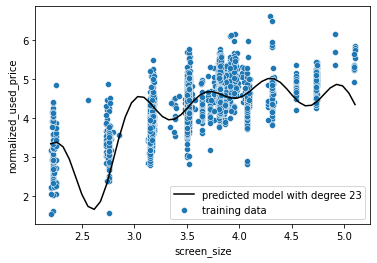

In [ ]:
sns.scatterplot(data = df, x = 'screen_size', y = 'normalized_used_price')
x_model = np.linspace(df['screen_size'].min(), df['screen_size'].max(), 50)
x_model_scaled = scaler.fit_transform(x_model.reshape(-1,1))

x_model_poly  = poly.fit_transform(x_model_scaled)
y_model = model.predict(x_model_poly)

plt.plot(x_model,  y_model, color = 'k')
plt.legend(['predicted model with degree '+ str(order), 'training data'])
plt.show()

### Ridge & Lasso Regression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kfold = KFold(n_splits= 10, shuffle=True, random_state=100)

steps = [("imp_mean", SimpleImputer()),
          ("scaler" , StandardScaler()),
          ("tranform" , PolynomialFeatures(degree = i)),
          ("rReg" , Ridge(alpha=0, normalize=True)),
          # ("lRag", Lasso(alpha=100, max_iter=20000, normalize=True))
          ]

pipeline = Pipeline(steps)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold)

print(cv_scores)

[   0.59003579    0.51757576    0.63236149    0.64028288    0.57608166
    0.5204681     0.61261178 -459.36963454    0.56119623    0.61775989]


In [ ]:
pr=PolynomialFeatures(degree = 23)

X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)

ridgeReg = Ridge(alpha=0.01, normalize=True)
ridgeReg.fit(X_train_pr, y_train)

Ypred_train = ridgeReg.predict(X_train_pr)
Ypred_test = ridgeReg.predict(X_test_pr)

ridgeReg.score(X_train_pr, y_train)

0.525188314304277

### Save Best_model.pkl for deployment

In [ ]:
import joblib 
X = df['screen_size'].values 
y = df['normalized_new_price'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

poly = PolynomialFeatures(degree = 23, include_bias=False) 
poly_features = poly.fit_transform(X_scaled.reshape(-1, 1))

lr = LinearRegression() 
polyReg = lr.fit(poly_features, y)
joblib.dump(model,'best_model.pkl')

Y_pred = model.predict(poly_features) 
rscore = model.score(poly_features, y) 
mse = mean_squared_error(y, Y_pred) 
mae = mean_absolute_error(y, Y_pred)